## Library imports:

In [68]:
import sys

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
from sklearn.manifold import TSNE

## Local Imports:
Modules (scripts) located in the same/parent folder of this python notebook.

In [3]:
sys.path.append('../')  # add parent folder to path
from mini_processing import get_minis_dataset, min_max_scaling
from mini_processing import paramaterize
import torch_clustering as clorch
import cluster_ae_builds as builds

## Set matlibplot style (colours etc.):

In [4]:
mpl.style.use('seaborn')

## Load minis dataset:
Load in sets of mini recordings (clipped with set amount of head and tail points relative to the detected mEPSC peak) stored in CSVs. The files in the target folder should be have consistent naming according to their condition (e.g. GABA only) with a trailing number (ex: `GABA0.csv`).
```css
Pipeline:
> load all of the CSVs contained in the given folder
> remove linear trend from the recording offset
> clip traces, removing excess leading and trailing points
> flip negative currents to positive
> normalize
```

In [30]:
datapath = "/media/geoff/Data/ss_minis/"

length = 383
minis, labels, label_strs = get_minis_dataset(
    datapath, start=350, end=350+length, norm='group_mean'
    # datapath, start=350, end=350+length, norm='feature'
)

## Build covolutional clustering encoder network, and fit:
In order to reduce the complex waveform of current over time for each mini into a smaller number of clusterable representative values, we will train an artificial neural network to extract arbitrary features for us. Although said features will not be human understandable, the hope is that they are *descriptive* enough of the input data that we can delineate samples that have come from separate distributions. To push our network towards successfully producing representations of the input data that will allow us to so, we will explicitly incentivize it to lump samples into clusters.

A common technique for **feature extraction** from the "unstructured" (non-tabular) input data is learned convolutional filtering. In machine learning applications, **convolution** is actually usually implemented as **cross-correlation**, however since the kernels are learned anyway, there is no practical difference. By sliding a small kernel over the temporal dimension, rather than learning an independent weight for each point in time, our feature extraction can be much more robust to variability since it does not rely on events occuring at the exact same location in order to be detected. Also, it dramatically cuts down on the number of parameters (weights) our network has to learn.

![title](crosscorrelation.gif)

The first stage involves several layers of convolutional filtering. The original input is a one channel recording over time, we then apply many filters (initialized randomly and learned), whose outputs are combined and serve as the input to the next layer of convolutions. The data is reduced over the time dimension by striding the convolutions (filter kernel moves >1 point with each step). This results in kernels filtering for larger temporal features as the data is transformed by the network.

![title](conv1d_manychannel.png)

The output from the last convolutional layer is flattened into a feature vector and fed in to a fully-connected layer for further dimensional reduction. Then, all of the transformations are mirrored (using the same weights), to re-create the input.

![title](simple_schematic.png)

The cost function used to train the network is a weighted combination of the mean squared-error (MSE) of the input vs the output construct, and the difference between current cluster quality and a more optimal clustering. With each batch of samples passed through the network, the weights used for convolution and matrix multiplication are adjusted to reduce cost function using gradiet descent.

In [87]:
# build network
autoencoder = builds.ae_build_9()

# fit network
autoencoder.fit(
    minis, 3, lr=1e-3, epochs=75, cluster_alpha=1.2, clust_mode='KLdiv',
    show_plot=True
)

epoch: 0 n_batches: 10
cost: 0.010340
epoch: 1 n_batches: 10
cost: 0.080828
epoch: 2 n_batches: 10
cost: 0.106711
epoch: 3 n_batches: 10
cost: 0.109715
epoch: 4 n_batches: 10
cost: 0.103660
epoch: 5 n_batches: 10
cost: 0.097740
epoch: 6 n_batches: 10
cost: 0.097044
epoch: 7 n_batches: 10
cost: 0.049384
epoch: 8 n_batches: 10
cost: 0.140642
epoch: 9 n_batches: 10
cost: 0.028281
epoch: 10 n_batches: 10
cost: 0.034774
epoch: 11 n_batches: 10
cost: 0.021114
epoch: 12 n_batches: 10
cost: 0.019178
epoch: 13 n_batches: 10
cost: 0.013388
epoch: 14 n_batches: 10
cost: 0.013383
epoch: 15 n_batches: 10
cost: 0.014466
epoch: 16 n_batches: 10
cost: 0.027511
epoch: 17 n_batches: 10
cost: 0.016407
epoch: 18 n_batches: 10
cost: 0.019268
epoch: 19 n_batches: 10
cost: 0.016283
epoch: 20 n_batches: 10
cost: 0.014526
epoch: 21 n_batches: 10
cost: 0.013878
epoch: 22 n_batches: 10
cost: 0.018308
epoch: 23 n_batches: 10
cost: 0.013527
epoch: 24 n_batches: 10
cost: 0.013945
epoch: 25 n_batches: 10
cost: 0.013

## Get dimensionally reduced representation of the data:
Input the minis, and take the transformation generated by the front half (encoder) of the network. We'll use that for clustering and displaying the data in a human comprehendable (2-dimensional) format.

In [88]:
reduced = autoencoder.get_reduced(minis)

## Assign cluster labels to each sample using K-means:

In [89]:
centres, clusters, _ = clorch.hard_kmeans(torch.from_numpy(reduced), 3)
centres, clusters = centres.cpu().numpy(), clusters.cpu().numpy()
counts, ratios = clorch.cluster_counts(clusters, labels)

Ratio of total population of each mini-set (column) that belongs to each cluster (row):

In [90]:
print("Cluster Breakdown:\n     "+(' '*7).join(label_strs)+'\n', ratios)

Cluster Breakdown:
     ACh       GABA       mixed
 [[0.3769955  0.08076923 0.26264591]
 [0.39991813 0.01923077 0.11478599]
 [0.22308637 0.9        0.62256809]]


## Further reduce the dimensionality of the encoders output:
If the encoder is not restricted to representing the data with 2 values (think xy coordinates), use t-SNE (t-distributed stochastic neighbour embedding) to embed the N-dimensional feature vector into 2 dimensions.

We also want to reduce the dimensionality of the cluster centres provided by our clustering algorithm (K-means), so we temporarily concatenate them to the mini dataset for the t-SNE run.

In [91]:
if reduced.shape[1] > 2:
    # also, reduce the cluster centres (TSNE must do all at once)
    reduced_centres = TSNE(
        n_components=2, perplexity=75, learning_rate=400, n_iter=1000
    ).fit_transform(np.concatenate([reduced, centres], axis=0))
    
    # split samples and centres
    reduced = reduced_centres[:-centres.shape[0], :]
    centres = reduced_centres[-centres.shape[0]:, :]
    
    del reduced_centres

## Plot scatters of the reduced mini waveforms:
Now that we have turned our minis from recordings to single points in a 2-dimensional coordinate space, we can display them in a scatter plot. Here, we have the same data presented twice, but with different labelling. 

On the left, each sample is labelled according to the dataset that it originated from (e.g. isolated events of a particular type, or mixed). On the right, the labels are given by running a clustering algorithm on the internal representation of the auto-encoder model.

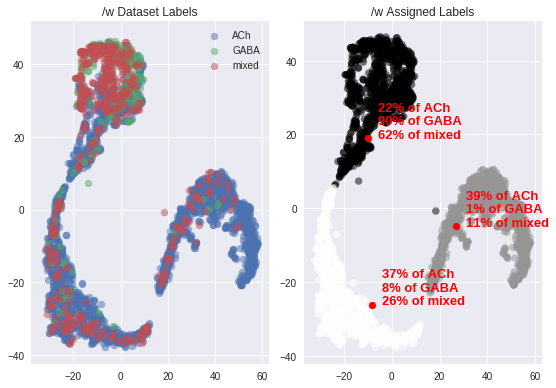

In [92]:
fig, ax = plt.subplots(1, 2)

# plot samples in 2d coordinate space, coloured by their true label
for label in np.unique(labels):
    grp = reduced[labels == label]
    ax[0].scatter(grp[:, 0], grp[:, 1], label=label_strs[label], alpha=.5)

# plot same samples, but coloured by their assigned cluster
ax[1].scatter(reduced[:, 0], reduced[:, 1], c=clusters, alpha=.5)

# plot cluster centres, with annotations stating what percentage of the
# total population of each label resides there
for (cx, cy), clstpop in zip(centres, ratios*100):
    ax[1].scatter(cx, cy, c='red')
    note = '\n'.join([
        "%d%% of %s" % (pop, lbl) for lbl, pop in zip(label_strs, clstpop)
    ])
    ax[1].annotate(
        note, (cx, cy), (10, 0), textcoords='offset pixels', c='red',
        fontsize=13, weight='heavy'
    )

ax[0].legend()
ax[0].set_title("/w Dataset Labels")
ax[1].set_title("/w Assigned Labels")

fig.tight_layout()

## Use the assigned labels to group minis and calculate prototypical examples:

In [93]:
proto_events = np.concatenate([
    np.mean(minis[clusters == i], axis=0)
    for i in np.unique(clusters)
], axis=0)

Normalize the proto-events to bring them into the same scales for display. 

In [94]:
# standard normalization (mean=0, var=1)
proto_norms = (
    proto_events - proto_events.mean(axis=1, keepdims=True)
) / proto_events.std(axis=1, keepdims=True)

# normalize on a 0 -> 1 scale (feature scaling)
proto_stretch = min_max_scaling(proto_events)

Plot calculated proto-events.

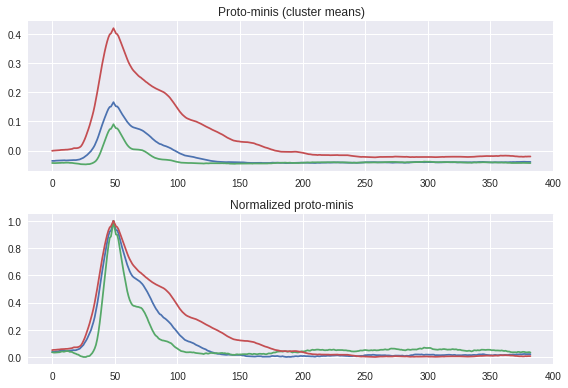

In [95]:
fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(proto_events.T)
ax1[0].set_title("Proto-minis (cluster means)")
ax1[1].plot(proto_stretch.T)
ax1[1].set_title("Normalized proto-minis")
fig1.tight_layout()

## Generate and plot example reconstructions of the inputs:
In order to learn to represent the input signals in a low-dimensional feature vector space, our model is trained not only to reduce the signals, but to re-build them. The weights used to manipulate the data as it is propagated through the network are adjusted to minimize the difference between the reconstructions and the original data. 

Since this model is also given the task of ensuring the reduced representations fall into a certain number of clusters, the quality of reconstructions may suffer somewhat. In general, the greater the dimensionality we allow the network to represent the data with in it's centre (between the encoder and decoder), and the less we punish the model for not producing clean clusters, the better the reconstructions will be (but the looser and less clear the resulting clusters will be).

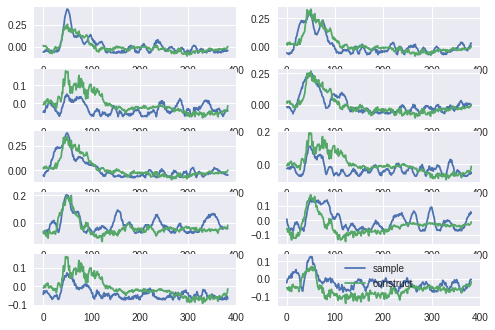

In [16]:
autoencoder.reconstruct(minis, batch_sz=10)

In [97]:
datapath = "/media/geoff/Data/ss_minis/"
long_minis, labels, label_strs = get_minis_dataset(
    datapath, start=0, end=1000, norm='group_mean'
)
long_minis = np.squeeze(long_minis)

In [178]:
def expfun(X, y0, tau, bias):
    return y0 * np.exp((-1/tau) * X) + bias


def get_exp_fits(mini, peak_time):
    head_y = np.flip(mini[:peak_time])
    tail_y = mini[peak_time-1:]
    
    head_x = np.arange(head_y.shape[0])
    tail_x = np.arange(tail_y.shape[0])
    
    (h_y0, h_tau, h_b), _ = curve_fit(expfun, head_x, head_y)
    (t_y0, t_tau, t_b), _ = curve_fit(expfun, tail_x, tail_y)
    
    return [h_y0, h_tau, h_b, t_y0, t_tau, t_b]


def moving_average(wave, kernel_sz=3) :
    cumul = np.cumsum(wave, dtype=float)
    cumul[kernel_sz:] = cumul[kernel_sz:] - cumul[:-kernel_sz]
    return cumul[kernel_sz - 1:] / kernel_sz


def get_rise_decay(wave, peak_time, kernel_sz=3):
    head_y = moving_average(np.flip(wave[:peak_time]), kernel_sz)
    tail_y = moving_average(wave[peak_time-1:], kernel_sz)
    
    thresh = (head_y.max() - head_y[:200].mean()) * .1
    
    rise = np.where(head_y < thresh)[0][0]
    decay = np.where(tail_y < thresh)[0][0]
    
    return [rise, decay]


def norm_metrics(metrics):
    sub_mean = metrics - metrics.mean(axis=0)
    return sub_mean / metrics.var(axis=0)

head params:
y0: 0.304, tau: 5.702, bias: -0.038
tail params:
y0: 0.316, tau: 50.506, bias: -0.053


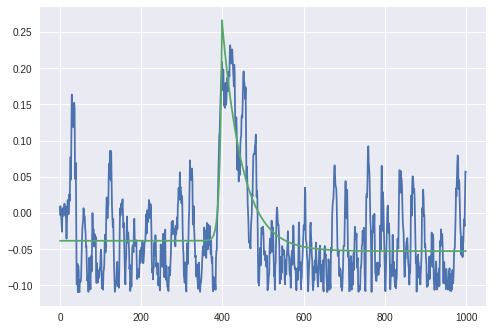

In [211]:
sample = long_minis[23, :]

h_y0, h_tau, h_b, t_y0, t_tau, t_b = get_exp_fits(sample, 400)

head_x = np.arange(head_y.shape[0])
tail_x = np.arange(tail_y.shape[0])

head_line = np.flip(expfun(head_x, h_y0, h_tau, h_b))
tail_line = expfun(tail_x, t_y0, t_tau, t_b)

fit_line = np.concatenate([head_line, tail_line[1:]]) # skip dupe point

plt.plot(sample)
plt.plot(fit_line)

print("head params:\ny0: %.3f, tau: %.3f, bias: %.3f" % (h_y0, h_tau, h_b))
print("tail params:\ny0: %.3f, tau: %.3f, bias: %.3f" % (t_y0, t_tau, t_b))

In [197]:
exp_metrics = np.array([
    get_exp_fits(mini, 400)
    for mini in long_minis
])

time_metrics = np.array([
    get_rise_decay(mini, 400, kernel_sz=5)
    for mini in long_minis
])

simple_metrics = np.stack([
    long_minis.max(axis=1),
    long_minis.sum(axis=1),
    long_minis.max(axis=1) / long_minis.sum(axis=1),
], axis=1)

# metrics = np.concatenate([exp_metrics, simple_metrics], axis=1)
# metrics = np.concatenate([time_metrics, simple_metrics], axis=1)
metrics = np.concatenate(
    [exp_metrics, time_metrics, simple_metrics], axis=1
)
# metrics = exp_metrics
# metrics = time_metrics

metrics = norm_metrics(metrics)

/home/geoff/miniconda3/envs/pytorchC10/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Cluster Breakdown:
    ACh     GABA     mixed
 [[0.98321736 0.73076923 0.82684825]
 [0.01678264 0.26923077 0.17315175]]
number of OPTICS clusters: 1
[-1  0] 0.5899906745414983
Cluster Breakdown:
    ACh     GABA     mixed
 [[0.68481375 0.22307692 0.32490272]
 [0.31518625 0.77692308 0.67509728]]


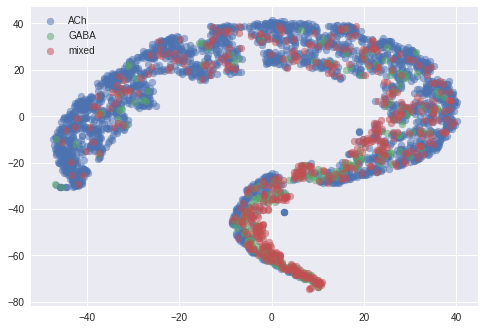

In [209]:
centres, clusters, _ = clorch.hard_kmeans(torch.from_numpy(metrics), 2)
centres, clusters = centres.cpu().numpy(), clusters.cpu().numpy()
counts, ratios = clorch.cluster_counts(clusters, labels)

print("Cluster Breakdown:\n    "+(' '*5).join(label_strs)+'\n', ratios)

reduced_centres = TSNE(
    n_components=2, perplexity=60, learning_rate=400, n_iter=1000
).fit_transform(np.concatenate([metrics, centres], axis=0))
# split samples and centres
reduced = reduced_centres[:-centres.shape[0], :]
centres = reduced_centres[-centres.shape[0]:, :]
del reduced_centres

for label in np.unique(labels):
    grp = reduced[labels == label]
    plt.scatter(grp[:, 0], grp[:, 1], label=label_strs[label], alpha=.5)
plt.legend()
    
from sklearn.cluster import OPTICS
opticlust = OPTICS(
    #min_samples=int(metrics.shape[0]*.11),  # min neighbours for core points
    min_cluster_size=.15,
).fit(reduced[:, :])
opt_labels = opticlust.labels_
print('number of OPTICS clusters:', np.max(opt_labels)+1)

print(np.unique(opt_labels), np.sum(opt_labels == -1)/len(opt_labels))
counts, ratios = clorch.cluster_counts(opt_labels, labels)
print("Cluster Breakdown:\n    "+(' '*5).join(label_strs)+'\n', ratios)

In [207]:
ach_exp_metrics = np.median(exp_metrics[labels == 0], axis=0)
gaba_exp_metrics = np.median(exp_metrics[labels == 1], axis=0)
mixed_exp_metrics = np.median(exp_metrics[labels == 2], axis=0)
print("RISE:")
print("\t          y0           tau            bias")
print("\tach:  ", ach_exp_metrics[:3])
print("\tgaba: ", gaba_exp_metrics[:3])
print("\tmixed:", mixed_exp_metrics[:3])
print("DECAY:")
print("\t          y0           tau            bias")
print("\tach:  ", ach_exp_metrics[3:])
print("\tgaba: ", gaba_exp_metrics[3:])
print("\tmixed:", mixed_exp_metrics[3:])

RISE:
	          y0           tau            bias
	ach:   [ 0.39723758  8.34177558 -0.04527293]
	gaba:  [0.75503688 8.49672553 0.01860055]
	mixed: [ 7.73705199e-01  1.13859497e+01 -1.03998935e-02]
DECAY:
	          y0           tau            bias
	ach:   [ 0.36346091 25.98693985 -0.050373  ]
	gaba:  [ 6.88390061e-01  5.83170382e+01 -1.34359347e-02]
	mixed: [ 6.53320561e-01  3.43832188e+01 -2.76724608e-02]


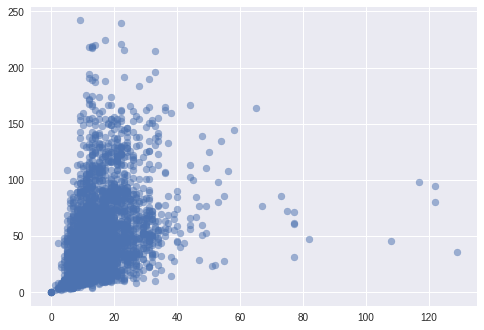

In [200]:
plt.scatter(time_metrics[:, 0], time_metrics[:, 1], alpha=.5)

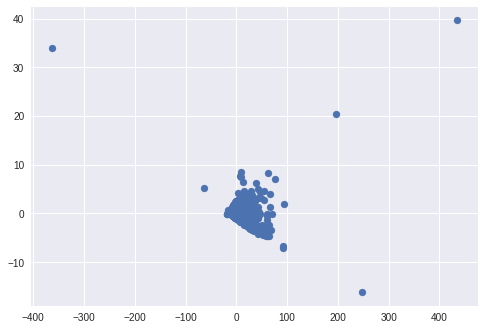

In [196]:
from sklearn.decomposition import PCA
pca = PCA()
reduced = pca.fit_transform(metrics)
plt.scatter(reduced[:, 0], reduced[:, 1])